In [1]:
import cpr_gym
import itertools
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

print(cpr_gym.engine.cpr_lib_version)

local-v0.2-22-g034935a-dirty


In [2]:
protocol_dict = dict(
    nakamoto=cpr_gym.protocols.nakamoto(),
    tailstorm8constant=cpr_gym.protocols.tailstorm(k=8, reward="constant"),
    tailstorm8discount=cpr_gym.protocols.tailstorm(k=8, reward="discount"),
)


def sparse(max_height=None, protocol=None, **kwargs):
    env = gym.make(
        "cpr_gym:core-v0",
        proto=protocol_dict[protocol],
        **kwargs,
        max_height=max_height,
        max_steps=max_height * 100,
    )
    env = cpr_gym.wrappers.SparseRewardPerBlockWrapper(env)
    return env


def dense(max_height=None, protocol=None, **kwargs):
    env = gym.make("cpr_gym:core-v0", proto=protocol_dict[protocol], **kwargs)
    env = cpr_gym.wrappers.DenseRewardPerBlockWrapper(env, max_height=max_height)
    return env


env_dict = dict(sparse=sparse, dense=dense)


def run_episode(env, policy=None):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    acc = 0
    done = False
    while not done:
        obs, reward, done, info = env.step(p(obs))
        acc += reward
    info["episode_reward"] = acc
    return info


def measure(env="sparse", n_episodes=1, policy="honest", **kwargs):
    env = env_dict[env](**kwargs)
    rewards = []
    runtime = []
    for i in range(n_episodes):
        try:
            info = run_episode(env, policy=policy)
            rewards.append(info["episode_reward"] / kwargs["alpha"])
            runtime.append(info["simulator_clock_rewarded"])
        except ValueError as e:
            warnings.warn(str(e))
            print(kwargs)
            print(f"policy: {policy}")
            print(e)
    return [np.median(rewards), np.median(runtime)]


alpha = np.linspace(0.1, 1.0, 10)
max_height = [2, 4, 8, 16, 32]

dfs = []
for protocol in protocol_dict.keys():
    env = env_dict["sparse"](max_height=1, protocol=protocol)
    df = pd.DataFrame(
        itertools.product(
            [protocol], alpha, max_height, env_dict.keys(), env.policies()
        ),
        columns=["protocol", "alpha", "max_height", "env", "policy"],
    )
    df["n_episodes"] = [
        int(np.ceil(1024 / h / env.puzzles_per_block())) for h in df.max_height
    ]

    df[["reward", "runtime"]] = df.apply(
        lambda x: pd.Series(measure(**x)),
        axis=1,
    )
    dfs.append(df)
d = pd.concat(dfs, ignore_index=True)
d

,protocol,alpha,max_height,env,policy,n_episodes,reward,runtime
0,nakamoto,0.1,2,sparse,sapirshtein-2016-sm1,512,0.0,1.533631
1,nakamoto,0.1,2,sparse,eyal-sirer-2014,512,0.0,1.738244
2,nakamoto,0.1,2,sparse,simple,512,0.0,1.789868
3,nakamoto,0.1,2,sparse,honest,512,0.0,1.812513
4,nakamoto,0.1,2,dense,sapirshtein-2016-sm1,512,0.0,1.632584
...,...,...,...,...,...,...,...,...
1195,tailstorm8discount,1.0,32,sparse,honest,4,1.0,257.596681
1196,tailstorm8discount,1.0,32,dense,override-catchup,4,1.0,262.070656
1197,tailstorm8discount,1.0,32,dense,override-block,4,1.0,256.368504
1198,tailstorm8discount,1.0,32,dense,release-block,4,1.0,251.205475


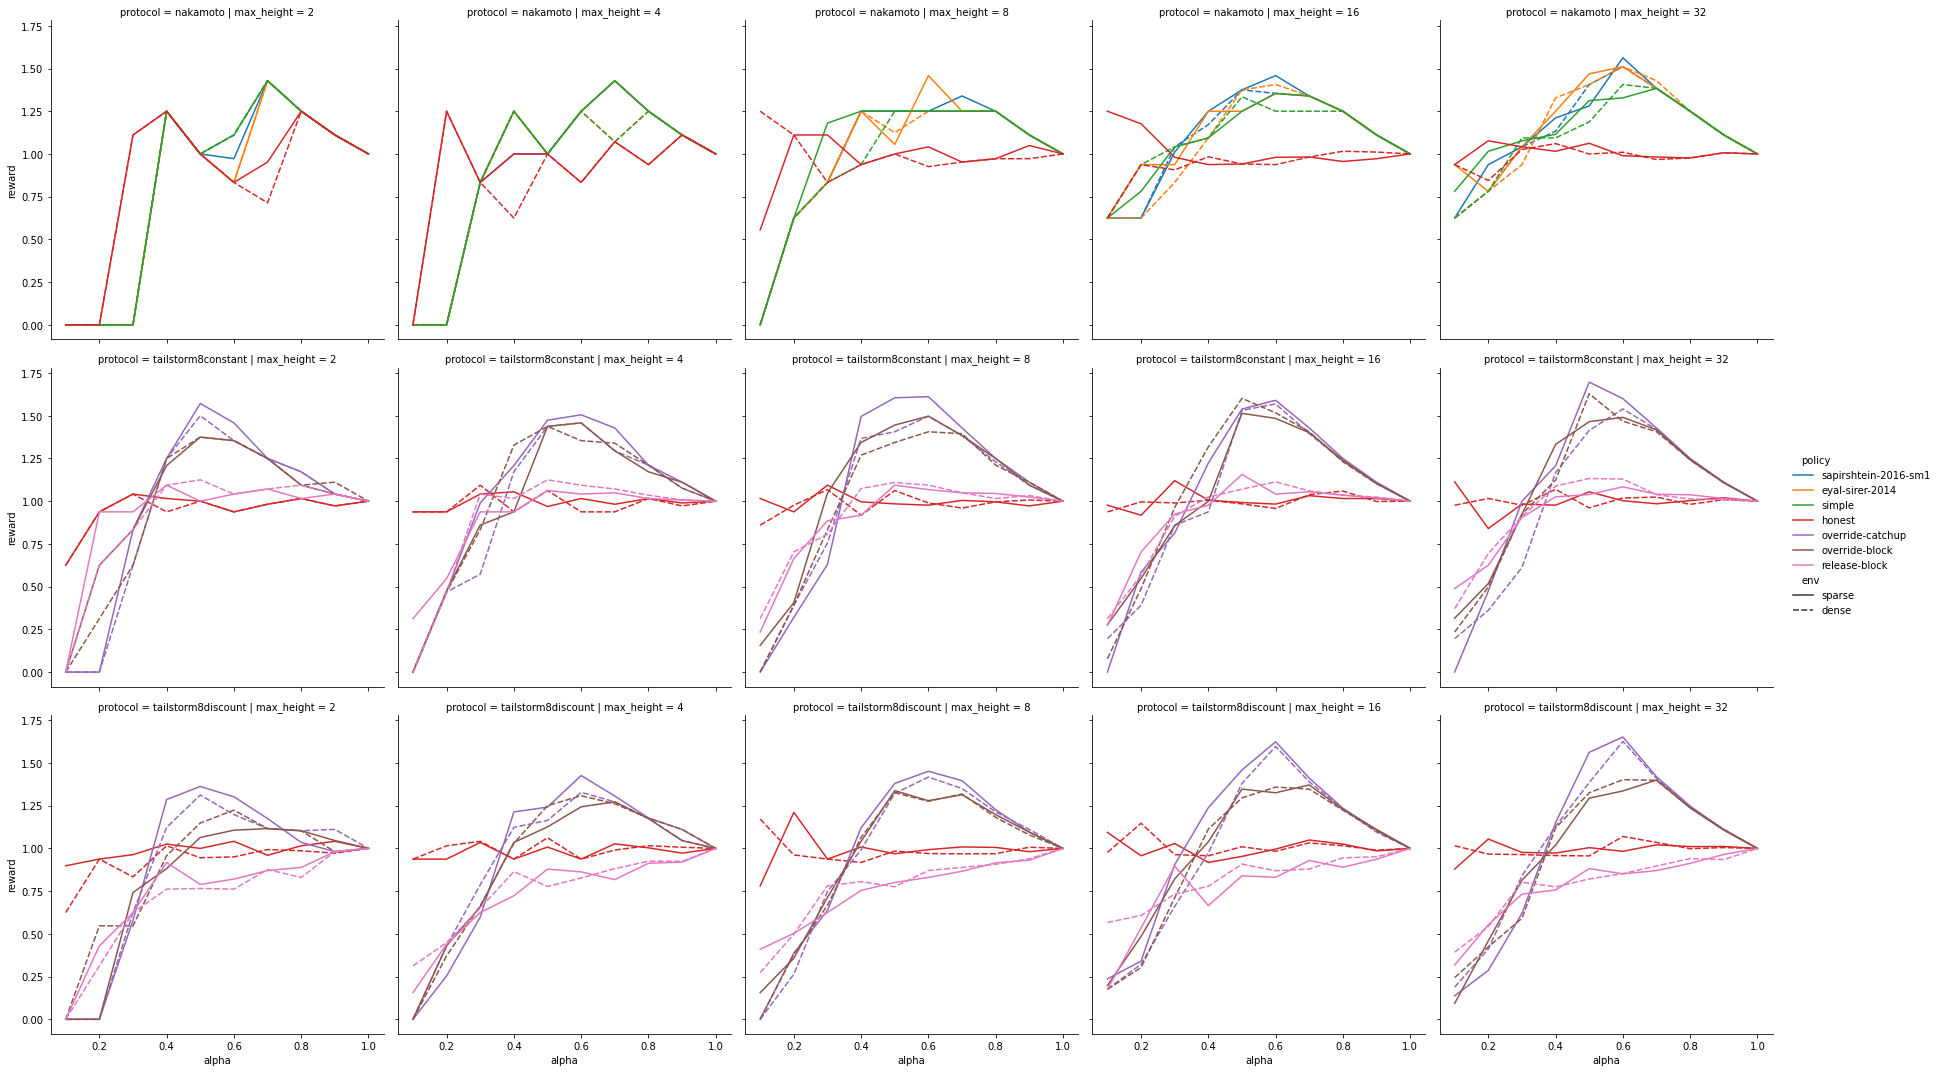

In [3]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    style="env",
    col="max_height",
    row="protocol",
)

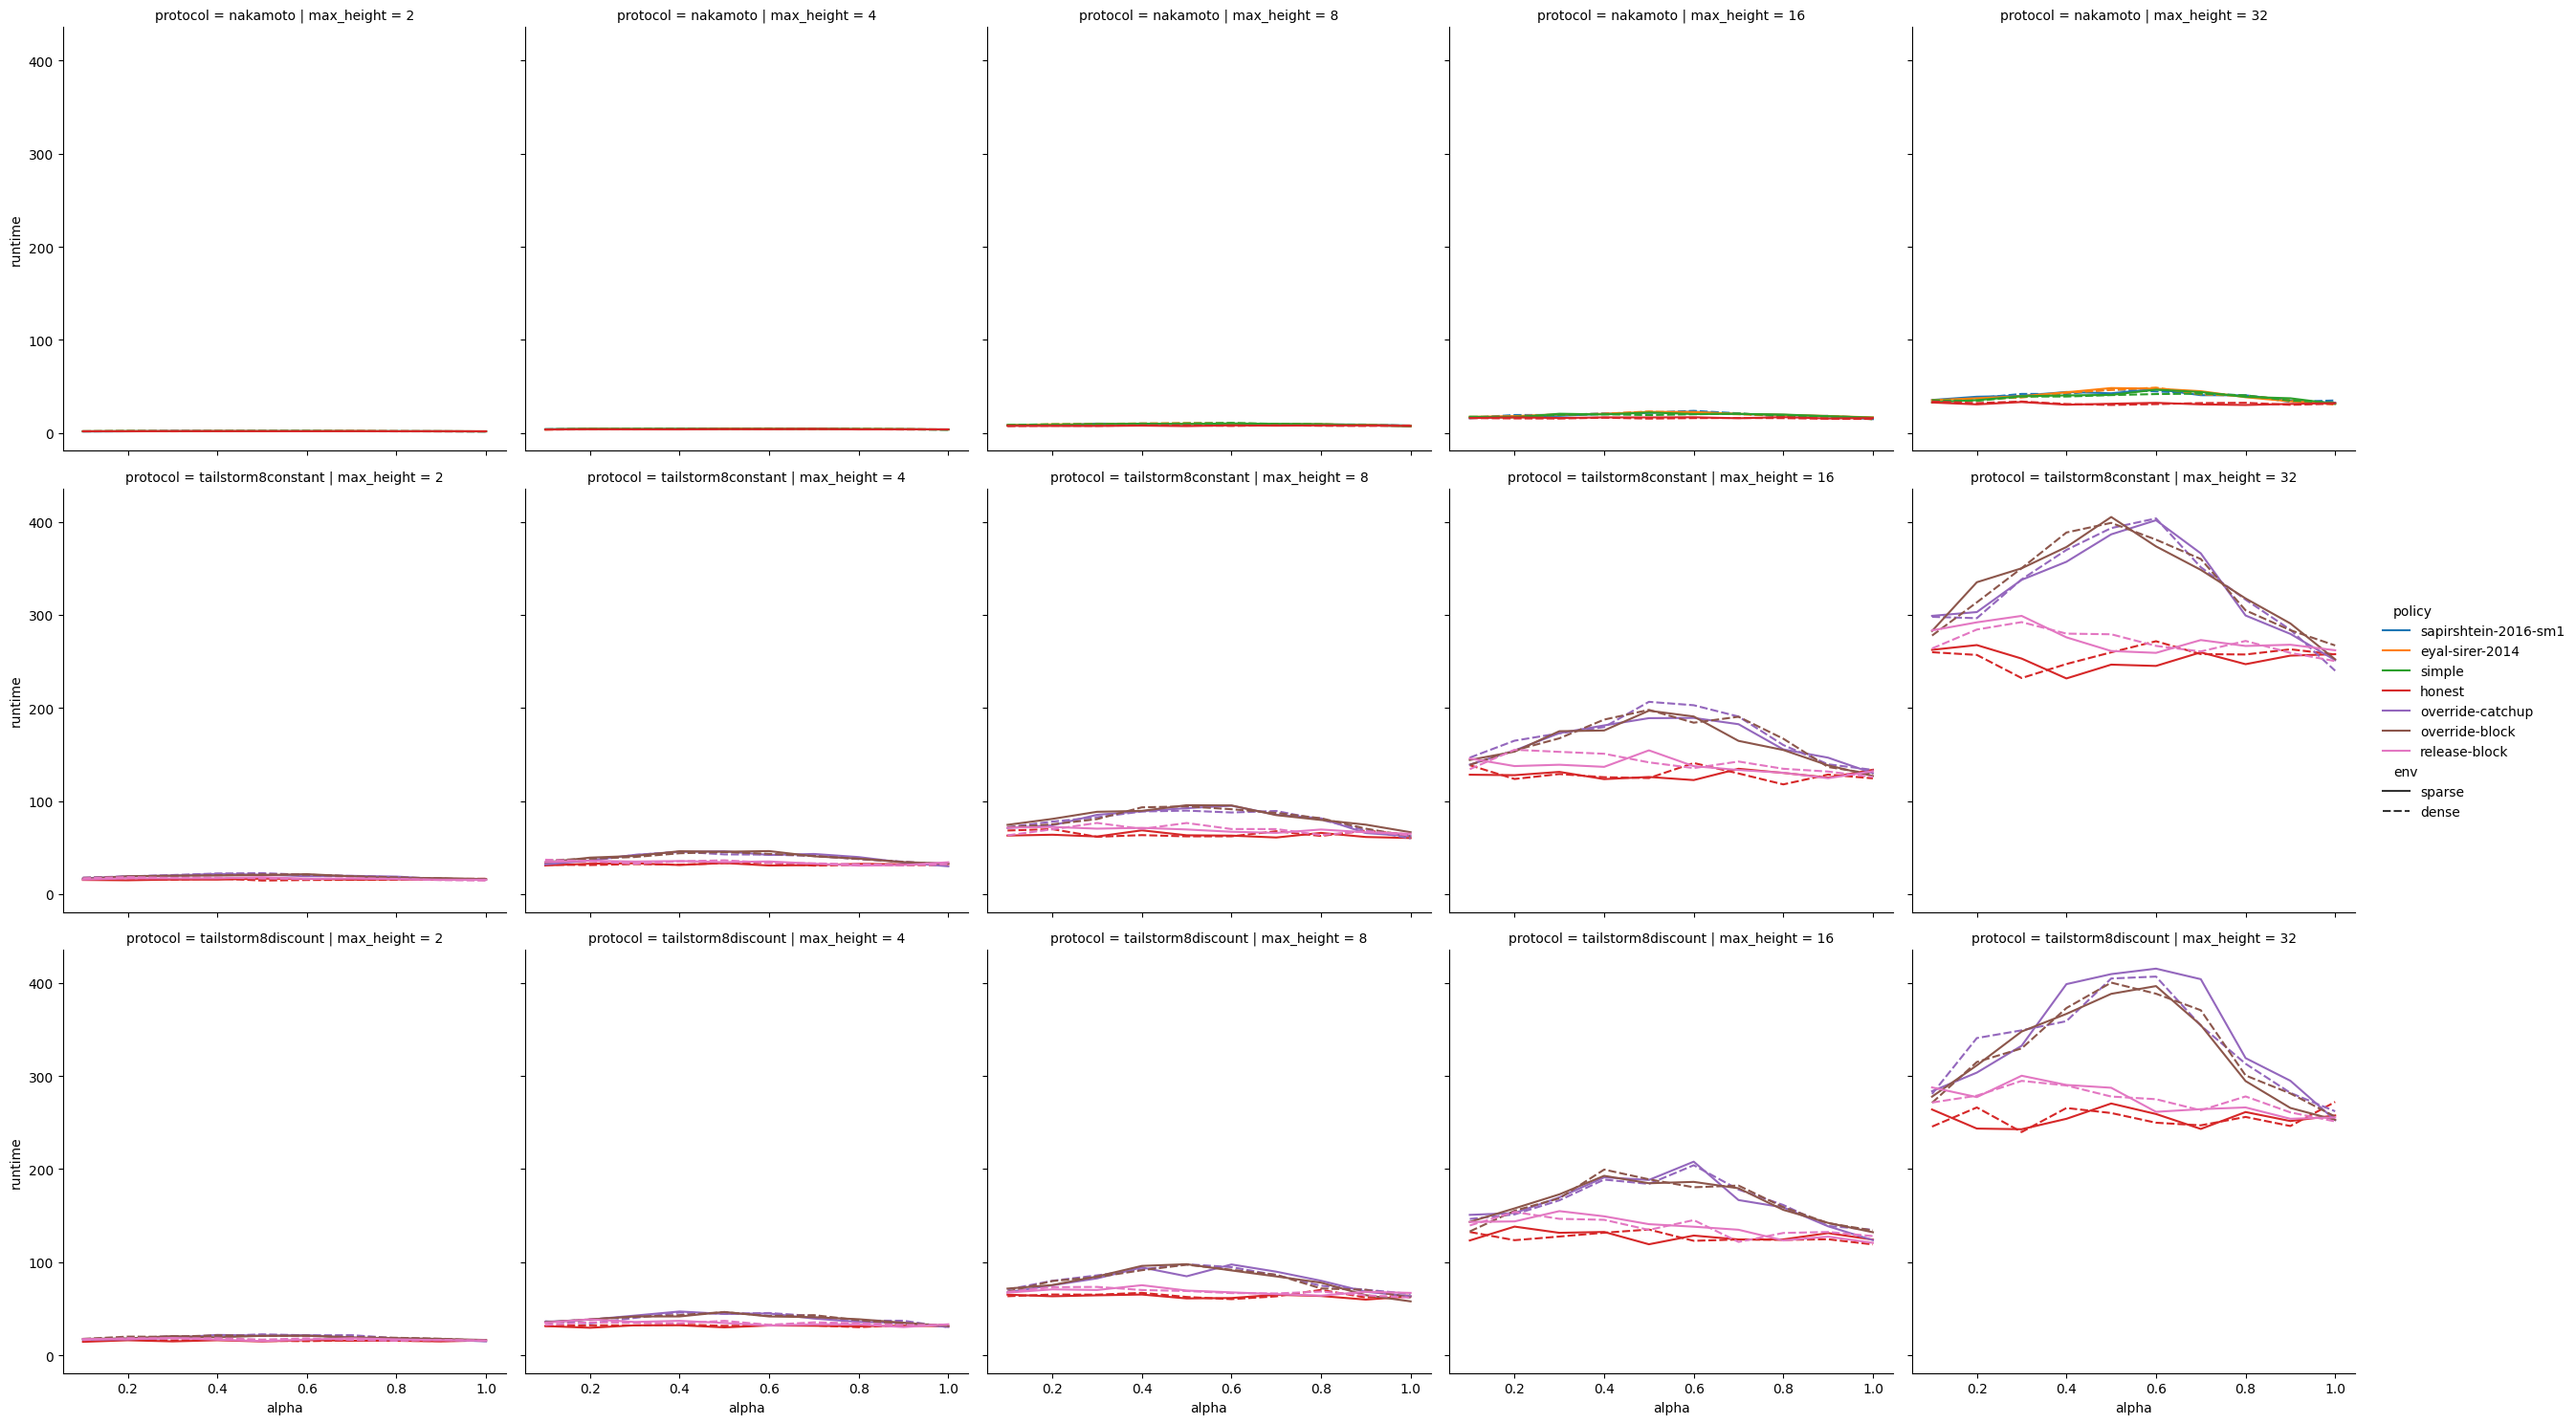

In [4]:
g = sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="runtime",
    hue="policy",
    style="env",
    col="max_height",
    row="protocol",
)